# K‑Fold T1c Model Comparison Dashboard

This notebook loads k‑fold training histories for **multiple models**, extracts the **best epoch per fold** (based on `val_accuracy` by default), and provides **publication‑quality** comparisons:

- Summary tables per model and combined
- Boxplot of validation accuracy across folds (per model)
- Mean±SD bar charts for validation accuracy and overfitting gap
- CSV export of all summarized results

> **Assumptions:** Each fold's history is stored as a NumPy `.npy` (dict-like) with keys at least: `accuracy`, `loss`, `val_accuracy`, `val_loss`. Filenames contain `fold_{i}` so the fold number can be parsed.


In [3]:
import glob
import re
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainmet import plotting as brain_met_plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.4f}".format)


In [4]:
history = np.load('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet152/2_classes_training/max_info/resnet152_00_2cls_slice_clin_layer_gray_seq[t1-t1c-t2-flair-mask]_normal_DA_lr_run_2025_12_29_18_21_38/history_resnet152_00_2cls_slice_clin_layer_gray_seq[t1-t1c-t2-flair-mask]_normal_DA_lr_run_2025_12_29_18_21_38.npy', allow_pickle=True).item()
print(history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall', 'val_f1_score', 'lr'])


## 1) Configure your models and file patterns

Edit the dictionary below so that each **key** is a human‑readable model name and each **value** is either a single **glob pattern (string)** or a **list of glob patterns** for runs that were split across multiple folders.

**Examples**
- **Single path:** `"ResNet50": "/path/to/logs/ResNet50/history_*_fold_*.npy"`
- **Split run:** `"EfficientNet": ["/path/part1/EffNet/history_*.npy", "/path/part2/EffNet/history_*.npy"]`

> The pattern must include `fold_` followed by a number (e.g., `fold_1`), which is used to map results to each fold.

In [5]:
# === EDIT ME: map model names to their glob patterns ===
MODEL_PATTERNS = {
    "Baseline CNN": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/control_conv/2_classes_training/control_conv/conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_14_14_03/history_conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_14_14_03.npy',
    "ResNet34": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet34/2_classes_training/control/resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_19_52_45/history_resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_19_52_45.npy",
    "ResNeXt50": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt50/2_classes_training/control/resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_31_12_48_20/history_resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_31_12_48_20.npy',
    "ResNeXt101": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt101/2_classes_training/control/resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_01_14_38_29/history_resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_01_14_38_29.npy",
    "ResNet152": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet152/2_classes_training/control/resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_17_19_31_38/history_resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_17_19_31_38.npy',
    "InceptionV3": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/transfer_inceptionv3/2_classes_training/control/transfer_inceptionv3_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_run_2025_09_01_16_03_27/history_transfer_inceptionv3_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_09_01_16_03_27.npy',
    "ResNet50V2": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/transfer_resnet50v2/2_classes_training/control/transfer_resnet50v2_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_run_2025_09_10_07_02_26/history_transfer_resnet50v2_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_09_10_07_02_26.npy'
}

# Metric used to pick the best epoch within each fold
SELECTION_METRIC = "val_auc"  # change to "val_loss" if desired
HIGHER_IS_BETTER = True            # set False if using "val_loss" or any metric where lower is better


## 3) Run the summary

In [6]:

per_model_results, combined_df = brain_met_plt.summarize_all_models(
    MODEL_PATTERNS,
    selection_metric=SELECTION_METRIC,
    higher_is_better=HIGHER_IS_BETTER
)

if combined_df.empty:
    print("No results found. Please check your MODEL_PATTERNS and file paths.")
else:
    display(combined_df.sort_values(["Model", "Fold"]).reset_index(drop=True))
    print("\nPer-model descriptive stats (Val Accuracy):\n")
    for name, df in per_model_results.items():
        if df.empty:
            print(f"- {name}: no data")
            continue
        desc = df["Val Accuracy"].describe()[["count","mean","std","min","max"]]
        print(f"\n{name}\n{desc}")


--- Processing model: Baseline CNN ---
--- Processing model: ResNet34 ---
--- Processing model: ResNeXt50 ---
--- Processing model: ResNeXt101 ---
--- Processing model: ResNet152 ---
--- Processing model: InceptionV3 ---
--- Processing model: ResNet50V2 ---


,Model,Fold,Best Epoch,Val Accuracy,Val AUC,Val Loss,Train Accuracy,Train AUC,Train Loss,History File,Overfitting Gap (Acc),Overfitting Gap (AUC)
0,Baseline CNN,0,50,0.5191,0.7374,1.0076,0.5309,0.5413,1.0228,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.0118,-0.1961
1,Baseline CNN,1,160,0.3793,0.7172,1.3115,0.6518,0.6991,0.9433,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2725,-0.0181
2,Baseline CNN,2,427,0.7049,0.7564,1.0613,0.7781,0.8667,0.7520,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.0732,0.1104
3,Baseline CNN,3,41,0.7473,0.7781,0.8987,0.5034,0.5150,1.0278,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,-0.2439,-0.2631
4,Baseline CNN,4,290,0.5512,0.7063,1.0981,0.6963,0.7567,0.8875,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.1451,0.0504
5,Baseline CNN,5,618,0.6448,0.7978,1.0566,0.8843,0.9566,0.5584,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.2395,0.1588
6,Baseline CNN,6,227,0.7121,0.8097,0.8562,0.6898,0.7473,0.8976,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,-0.0223,-0.0624
7,Baseline CNN,7,129,0.6389,0.7605,0.9142,0.6077,0.6514,0.9747,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,-0.0312,-0.1091
8,Baseline CNN,8,223,0.6531,0.6967,1.0727,0.6377,0.7024,0.9371,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,-0.0153,0.0056
9,Baseline CNN,9,218,0.2975,0.6906,2.1568,0.6576,0.7129,0.9249,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Trai...,0.3601,0.0223



Per-model descriptive stats (Val Accuracy):


Baseline CNN
count   10.0000
mean     0.5848
std      0.1485
min      0.2975
max      0.7473
Name: Val Accuracy, dtype: float64

ResNet34
count   10.0000
mean     0.6423
std      0.1446
min      0.3038
max      0.7849
Name: Val Accuracy, dtype: float64

ResNeXt50
count   10.0000
mean     0.6581
std      0.1073
min      0.4367
max      0.7929
Name: Val Accuracy, dtype: float64

ResNeXt101
count   10.0000
mean     0.6086
std      0.1461
min      0.2975
max      0.7143
Name: Val Accuracy, dtype: float64

ResNet152
count   10.0000
mean     0.6621
std      0.1079
min      0.3966
max      0.7576
Name: Val Accuracy, dtype: float64

InceptionV3
count   10.0000
mean     0.5441
std      0.1596
min      0.2581
max      0.7424
Name: Val Accuracy, dtype: float64

ResNet50V2
count   10.0000
mean     0.6110
std      0.0598
min      0.5251
max      0.7037
Name: Val Accuracy, dtype: float64


## 4) Boxplot: Validation Accuracy across folds (per model)

This figure shows the **distribution** of validation accuracies across folds for each model. Use it to visually compare model stability and central tendency.


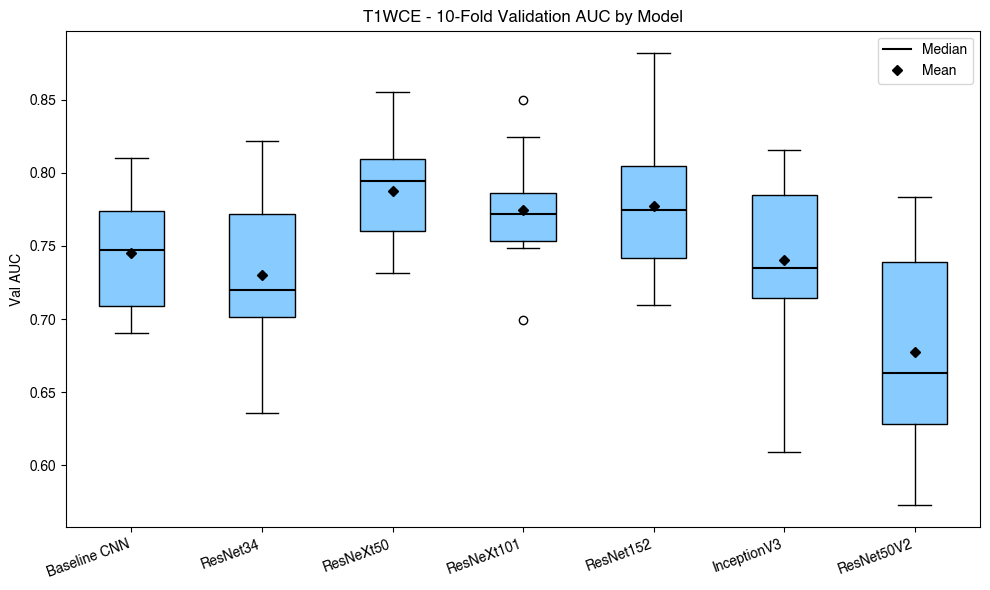

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'T1WCE - 10-Fold Validation AUC by Model'}, ylabel='Val AUC'>)

In [7]:
#brain_met_plt.plot_model_comparison_boxplot(per_model_results, metric="Val Accuracy", figsize=(10, 6))

brain_met_plt.plot_model_comparison_boxplot_paper(per_model_results, metric="Val AUC", title_addition = "T1WCE",figsize=(10, 6))


## 5) Mean ± SD: Validation Accuracy

Bars show the mean validation accuracy per model with standard‑deviation error bars (across folds).

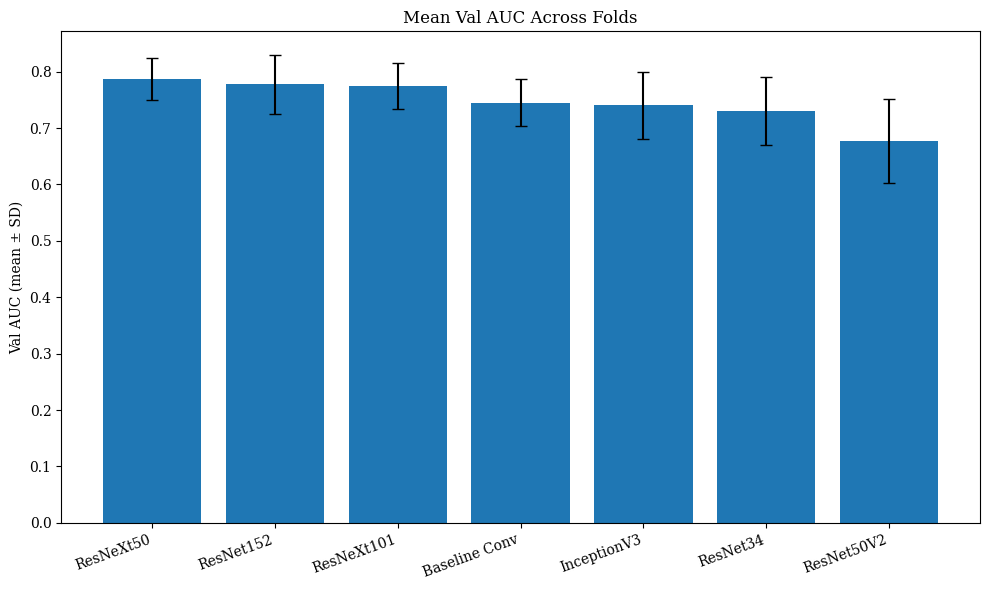


Summary statistics for Val AUC:
                mean    std
Model                      
ResNeXt50     0.7875 0.0370
ResNet152     0.7774 0.0526
ResNeXt101    0.7744 0.0415
Baseline Conv 0.7451 0.0422
InceptionV3   0.7401 0.0592
ResNet34      0.7303 0.0605
ResNet50V2    0.6776 0.0743


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Val AUC Across Folds'}, ylabel='Val AUC (mean ± SD)'>)

In [6]:

brain_met_plt.plot_model_summary_bar(combined_df, metric="Val AUC", figsize=(10, 6))

## 6) Mean ± SD: Overfitting Gap (Train Acc − Val Acc)

Positive values indicate the model fits training data better than validation (**overfitting**).

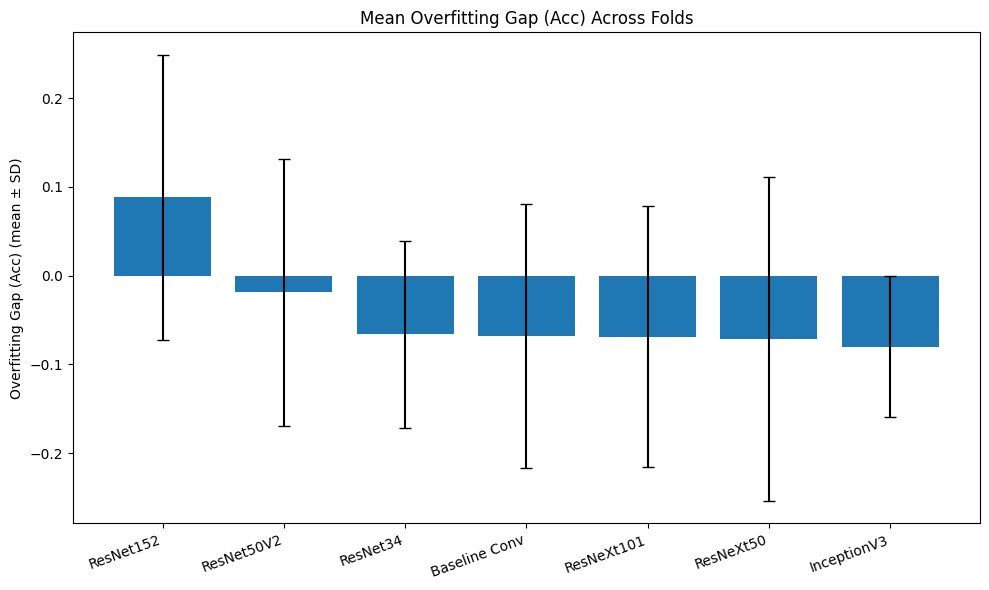


Summary statistics for Overfitting Gap (Acc):


,mean,std
Model,,
ResNet152,0.0882,0.1609
ResNet50V2,-0.0187,0.1504
ResNet34,-0.0662,0.1057
Baseline Conv,-0.0682,0.1486
ResNeXt101,-0.0686,0.1471
ResNeXt50,-0.0713,0.1828
InceptionV3,-0.0799,0.0796


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Overfitting Gap (Acc) Across Folds'}, ylabel='Overfitting Gap (Acc) (mean ± SD)'>)

In [ ]:
brain_met_plt.plot_model_summary_bar(combined_df, metric="Overfitting Gap (Acc)", figsize=(10, 6))

## 7) Export combined summary to CSV

In [ ]:
brain_met_plt.save_summary_to_csv(combined_df, output_path="kfold_summary_experiment_01.csv")

Saved combined summary to: /Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/notebooks/results/kfold_combined_summary.csv


---

### Notes
- Replace `MODEL_PATTERNS` with the appropriate paths for your project.
- If your model selection should be based on **minimum validation loss**, set:
  ```python
  SELECTION_METRIC = "val_loss"
  HIGHER_IS_BETTER = False
  ```
- Ensure your history files contain the necessary keys. If not, adapt the code accordingly.
- Each plot uses **matplotlib** only, with one chart per figure and default styling (no custom colors), to be compatible with strict pipelines.
